In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error


tsla = pd.read_csv("tsla_ml.csv")
att = pd.read_csv("att_ml.csv")
ko = pd.read_csv("ko_ml.csv")
spy = pd.read_csv("spy_ml.csv")
metrics_df = pd.read_csv("metrics_ml.csv")

In [ ]:
spy_train_cnt = round(len(spy["c"]) * .8)
spy_test = len(spy["c"]) - spy_train_cnt
spy_train = spy.iloc[:spy_train_cnt].drop("Unnamed: 0", axis=1)

In [ ]:
pipeline = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)

pipeline.fit(tsla["time"].to_frame(), tsla.Price)

y_new_ = pd.Series(pipeline.predict(X=tsla["time"].to_frame()), index=tsla.set_index("t").index)

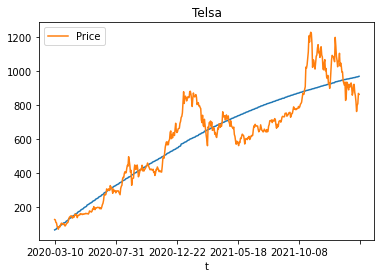

In [ ]:
y_new_.plot.line()
tsla.set_index("t")["Price"].plot.line(legend=True, title="Telsa")

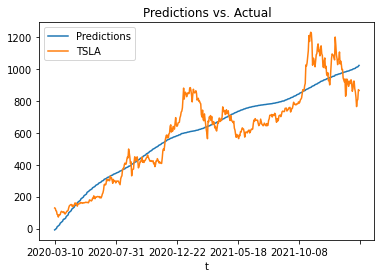

In [ ]:
pip = make_pipeline(
    make_union(
        PolynomialFeatures(degree=3, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * np.pi * 2 * t)),
        FunctionTransformer(lambda t: np.cos(2 * np.pi * 2 * t))
    ),
    LinearRegression()
)

pip.fit(tsla["time"].to_frame(), tsla.Price)
y_pred_ = pd.Series(pip.predict(X=tsla["time"].to_frame()), index=tsla.set_index("t").index)

y_pred_.plot.line(label="Predictions", legend=True)
tsla.set_index("t")["Price"].plot.line(label="TSLA", legend=True, title="Predictions vs. Actual")

In [ ]:
scores = cross_val_score(pip, tsla["time"].to_frame(), y=tsla["Price"], scoring="neg_mean_absolute_error", cv=6)
-scores.mean()

149.97183365180402

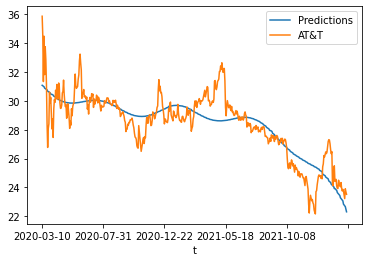

In [ ]:
att_pip = make_pipeline(
    make_union(
        PolynomialFeatures(degree=3, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * np.pi * 2 * t)),
        FunctionTransformer(lambda t: np.cos(2 * np.pi * 2 * t))
    ),
    LinearRegression()
)

att_pip.fit(att["time"].to_frame(), att.Price)
y_pred_ = pd.Series(att_pip.predict(X=att["time"].to_frame()), index=att.set_index("t").index)

y_pred_.plot.line(label="Predictions", legend=True)
att.set_index("t")["Price"].plot.line(label="AT&T", legend=True)

In [ ]:
scores = cross_val_score(att_pip, att["time"].to_frame(), y=att["Price"], scoring="neg_mean_absolute_error", cv=6)
-scores.mean()

1.837318228332963

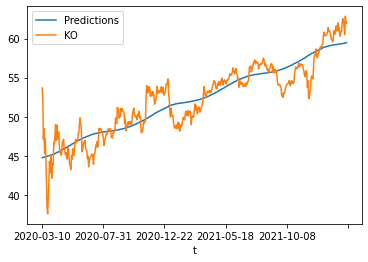

In [ ]:
kopip = make_pipeline(
    make_union(
        PolynomialFeatures(degree=2, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * np.pi * 2 * t)),
        FunctionTransformer(lambda t: np.cos(2 * np.pi * 2 * t))
    ),
    LinearRegression()
)

kopip.fit(ko["time"].to_frame(), ko.Price)
y_pred_ = pd.Series(kopip.predict(X=ko["time"].to_frame()), index=ko.set_index("t").index)

y_pred_.plot.line(label="Predictions", legend=True)
ko.set_index("t")["Price"].plot.line(label="KO", legend=True)

In [ ]:
scores = cross_val_score(kopip, ko["time"].to_frame(), y=ko["Price"], scoring="neg_mean_absolute_error", cv=6)
-scores.mean()

2.027838480474565

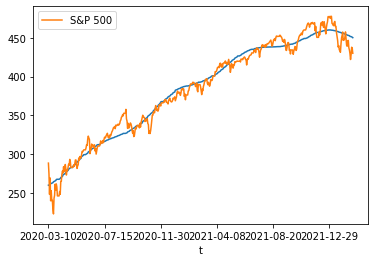

In [ ]:
spx = make_pipeline(
    make_union(
        PolynomialFeatures(degree=3, include_bias=False),
        FunctionTransformer(lambda t: np.sin(2 * np.pi * 2 * t)),
        FunctionTransformer(lambda t: np.cos(2 * np.pi * 2 * t))
    ),
    LinearRegression()
)

spx.fit(spy["time"].to_frame(), spy["c"])
spx_ = pd.Series(spx.predict(X=spy["time"].to_frame()), index=spy.set_index("t").index)

spx_.plot.line()
spy.set_index("t")["c"].plot.line(label="S&P 500", legend=True)

In [ ]:
scores = cross_val_score(spx, spy["time"].to_frame(), y=spy["c"], scoring="neg_mean_absolute_error", cv=6)
-scores.mean()

16.730975650152345

#PREDICT NEXT PRICE - BUY OR SELL

In [ ]:
future = [spy["time"][-1:].iloc[0] + spy["time"][-2:].diff().iloc[1]]
future = pd.DataFrame(future, columns=["time"])

spx.predict(future[["time"]])

array([449.56723022])

In [ ]:
spy.c[-1:]

542    429.98
Name: c, dtype: float64

In [ ]:
stock = att["Price"]
scaler = MinMaxScaler()
stock_scaled = scaler.fit_transform(stock.to_frame())

In [ ]:
train_data = stock_scaled[:spy_train_cnt, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

seq = Sequential()
seq.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
seq.add(LSTM(100, return_sequences=False))
seq.add(Dense(25))
seq.add(Dense(1))
seq.compile(optimizer="adam", loss="mean_absolute_error")

In [ ]:
seq.fit(x_train, y_train, batch_size=1)

374/374 [==============================] - 17s 35ms/step - loss: 0.0538


In [ ]:
test_data = stock_scaled[spy_train_cnt - 60:, :]

x_test = []
y_test = stock.to_frame().iloc[spy_train_cnt:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
y_predict_ = seq.predict(x_test)
y_predict_ = scaler.inverse_transform(y_predict_)

In [ ]:
mean_absolute_error(y_test, y_predict_)

0.6434295712984526

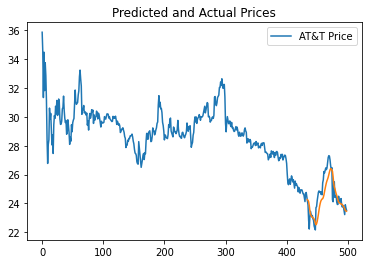

In [ ]:
predictions = pd.Series(np.squeeze(y_predict_), index=y_test.index)
stock.plot.line(label="AT&T Price", legend=True)
predictions.plot.line(title="Predicted and Actual Prices")

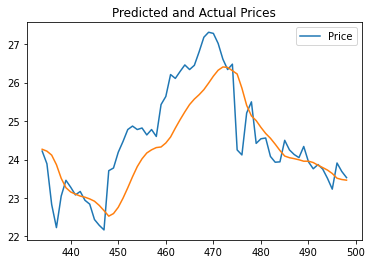

In [ ]:
y_test.plot.line(label="KO Price", legend=True)
predictions.plot.line(title="Predicted and Actual Prices")

In [ ]:
returns_df = pd.DataFrame()
returns_df["actual"] = y_test
returns_df["predicted"] = predictions
returns_df["trend"] = returns_df["predicted"].diff().replace(np.nan, 0)

In [ ]:
returns_df["diff"] = returns_df["actual"] >= returns_df["predicted"]
returns_df["diff"] = returns_df["diff"].map({True: "ABOVE", False:"BELOW"})
returns_df

,actual,predicted,trend,diff
434,24.22,24.267477,0.000000,BELOW
435,23.89,24.217758,-0.049719,BELOW
436,22.83,24.114857,-0.102901,BELOW
437,22.23,23.866394,-0.248463,BELOW
438,23.05,23.512678,-0.353716,BELOW
...,...,...,...,...
494,23.51,23.725451,-0.065063,BELOW
495,23.23,23.636835,-0.088615,BELOW
496,23.91,23.514099,-0.122736,ABOVE
497,23.69,23.480709,-0.033390,ABOVE


In [ ]:
returns_df.actual.corr(returns_df.predicted)

0.8005195761978207

In [ ]:
def get_trade(dataframe):
  in_trade = False
  buy_price = 0
  sell_price = 0
  pi = 0
  t = 0
  rets = []
  for i in range(0, len(dataframe["actual"])):
    actual = dataframe["actual"].iloc[i]
    if dataframe["diff"].iloc[i] == "ABOVE" and in_trade is False and dataframe["trend"].iloc[i] > 0:
      print("BIndex: " + str(i + 434))
      buy_price = actual
      in_trade = True
      print("buy actual: %d" % actual)
      t += 1
    elif dataframe["diff"].iloc[i] == "BELOW" and in_trade is True:
      print("SIndex: " + str(i + 434))
      sell_price = actual
      in_trade = False
      pi += sell_price - buy_price
      rets.append((buy_price, sell_price - buy_price))
      print("sell actual: %d" % actual)
    else:
      pass
  return rets

In [ ]:
trades = pd.DataFrame(get_trade(returns_df), columns=["Cost", "Gross Profit"])

BIndex: 449
buy actual: 23
SIndex: 473
sell actual: 26


In [ ]:
trades["return"] = trades["Gross Profit"] / trades["Cost"]
trades["weight"] = ((trades["Cost"] / trades["Cost"].sum()))
trades["wreturn"] = (trades["Gross Profit"] / trades["Cost"]) * trades.weight
trades["return"].sum()

0.10765349032800667

In [ ]:
(returns_df.iloc[-1]["actual"] - returns_df.iloc[0]["actual"]) / returns_df.iloc[0]["actual"]

-0.02848885218827406